In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import numpy as np


def read_dimacs_graph(filename):
    G = nx.Graph()
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("a"):
                _, u, v, w = line.strip().split()
                G.add_edge(int(u), int(v), weight=int(w))
    return G


def plot_degree_distribution(G: nx.Graph, name=""):
    """
    Degree of a node in a network is the number of connections it has to other nodes
    Degree distribution is the probability distribution of these degrees over the whole network.
    """
    degrees = [G.degree(n) for n in G.nodes()]

    plt.hist(
        degrees,
        bins=range(min(degrees), max(degrees) + 2),
        align="left",
        edgecolor="black",
    )
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title(f"Degree Distribution - {name}")
    plt.show()


def plot_weight_distribution(G: nx.Graph, name=""):
    weights1 = [d["weight"] for _, _, d in G.edges(data=True)]

    plt.figure(figsize=(8, 8))
    plt.hist(weights1, bins="auto", alpha=0.6, edgecolor="black")
    plt.xscale("log")
    plt.xlabel("Edge Weight (log scale)")
    plt.ylabel("Frequency")
    plt.title(f"Edge Weight Distribution: {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


def shortest_path_kernel(graphs, max_paths=5, n_samples=10):
    def normalize_2d(matrix):
        norm = np.linalg.norm(matrix)
        matrix = matrix / norm  # normalized matrix
        return matrix

    phi_train = np.zeros((len(graphs), max_paths))

    for i, graph in enumerate(graphs):
        for j in range(n_samples):
            pair = np.random.choice(graph.nodes(), 2)
            source, target = pair[0], pair[1]

            path_length = nx.shortest_path_length(graph, source, target)
            path_length = min(path_length, max_paths - 1)

            phi_train[i][path_length] += 1

    res = np.dot(phi_train, phi_train.T)

    return normalize_2d(res)


def info(G: nx.Graph, name: str = ""):
    V = G.number_of_nodes()
    E = G.number_of_edges()
    max_E = V * (V - 1) // 2
    density = E / max_E if max_E > 0 else 0
    components = nx.number_connected_components(G)

    print(f"Graph: {name}")
    print(f"  Nodes (V): {V}")
    print(f"  Edges (E): {E}")
    print(f"  Max Edges (Complete Graph): {max_E}")
    print(f"  Density: {density:.8f}")
    print(f"  Connected Components: {components}\n")

    return {
        "Graph": name,
        "Nodes": V,
        "Edges": E,
        "Max Edges": max_E,
        "Density": density,
        "Connected Components": components,
    }


In [2]:
DISTANCE_GRAPH_FILES = {
    "Great Lakes": "USA-road-d.LKS.gr",
    "California and Nevada": "USA-road-d.CAL.gr",
    "Northeast USA": "USA-road-d.NE.gr",
    "Northwest USA": "USA-road-d.NW.gr",
    "Florida": "USA-road-d.FLA.gr",
    "Colorado": "USA-road-d.COL.gr",
    "San Francisco Bay Area": "USA-road-d.BAY.gr",
    "New York City": "USA-road-d.NY.gr",
}
TIME_GRAPH_FILES = {
    "Great Lakes": "USA-road-t.LKS.gr",
    "California and Nevada": "USA-road-t.CAL.gr",
    "Northeast USA": "USA-road-t.NE.gr",
    "Northwest USA": "USA-road-t.NW.gr",
    "Florida": "USA-road-t.FLA.gr",
    "Colorado": "USA-road-t.COL.gr",
    "San Francisco Bay Area": "USA-road-t.BAY.gr",
    "New York City": "USA-road-t.NY.gr",
}

In [3]:
def analyze_graphs(graph_files):
    density = []
    for name, filename in graph_files.items():
        G = read_dimacs_graph(filename)

        res = info(G, name=name)
        density.append(res["Density"])

        plot_weight_distribution(G, name)

    print(f"MEAN DENSITY: {np.mean(np.array(density))}.")


def compare_graphs(graph_files):
    """Example graph comparing using graph kernel."""
    graphs = []

    for _, filename in tqdm.tqdm(graph_files.items()):
        G = read_dimacs_graph(filename)
        graphs.append(G)

    return shortest_path_kernel(graphs, 1000, 50)

In [4]:
# print("DISTANCE GRAPHS")
# analyze_graphs(DISTANCE_GRAPH_FILES)

# print("TIME GRAPHS")
# analyze_graphs(TIME_GRAPH_FILES)

G_D = read_dimacs_graph("USA-road-d.LKS.gr")
G_T = read_dimacs_graph("USA-road-t.LKS.gr")
G_R = read_dimacs_graph("USA-road-d.LKS.random.gr")
G_S = read_dimacs_graph("USA-road-d.LKS.shuffle.gr")

In [5]:
from fitter import Fitter

weights_d = [d["weight"] for _, _, d in G_D.edges(data=True)]
weights_t = [d["weight"] for _, _, d in G_T.edges(data=True)]
weights_s = [d["weight"] for _, _, d in G_S.edges(data=True)]
weights_r = [d["weight"] for _, _, d in G_R.edges(data=True)]


2025-05-24 15:39:43.527 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.0)
2025-05-24 15:39:43.604 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)
2025-05-24 15:39:45.997 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,2.368462e-09,3578.969944,3618.085510,inf,0.043644,0.0
expon,7.506336e-09,6703.696670,6729.773715,inf,0.107809,0.0
norm,7.889204e-08,52264.335249,52290.412294,inf,0.222461,0.0


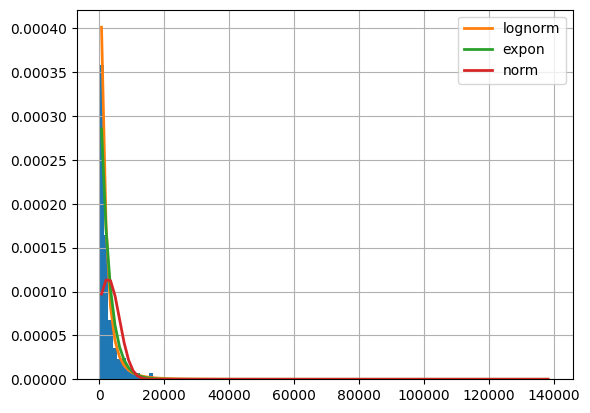

In [6]:
f = Fitter(weights_d, distributions=["expon", "norm", "lognorm"],timeout=10)
f.fit()
f.summary()

2025-05-24 15:39:47.794 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.0)
2025-05-24 15:39:47.851 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)
2025-05-24 15:39:51.865 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,3.931876e-10,3792.709088,3831.824654,inf,0.039639,0.0
expon,1.196697e-09,7158.928522,7185.005566,inf,0.103742,0.0
norm,1.309320e-08,57525.750111,57551.827156,inf,0.222197,0.0


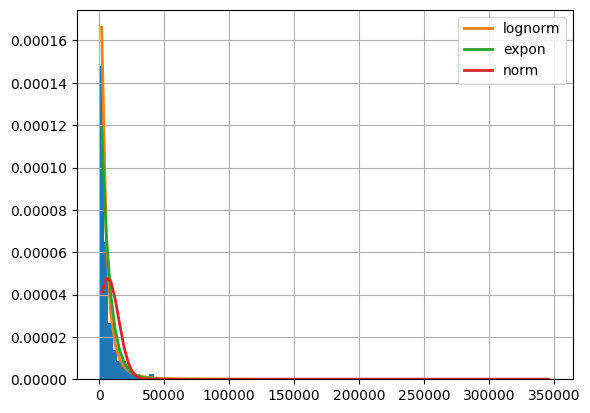

In [7]:
f = Fitter(weights_t, distributions=["expon", "norm", "lognorm"], timeout=10)
f.fit()
f.summary()

2025-05-24 15:39:53.598 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.0)
2025-05-24 15:39:53.680 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)
2025-05-24 15:39:56.496 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,2.337955e-09,3575.170357,3614.285923,inf,0.043284,0.0
expon,7.504743e-09,6698.187698,6724.264743,inf,0.107547,0.0
norm,7.878373e-08,52181.080496,52207.157541,inf,0.222079,0.0


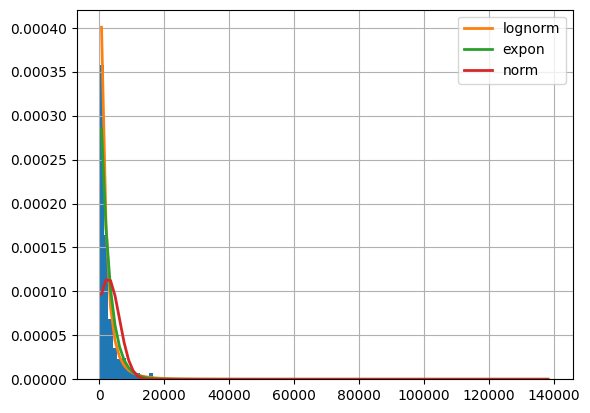

In [8]:
f = Fitter(weights_s, distributions=["expon", "norm", "lognorm"], timeout=10)
f.fit()
f.summary()

2025-05-24 15:39:57.907 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.0)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
uniform,3.032418e-07,923.02397,949.101014,0.000015,0.010069,1.333696e-299


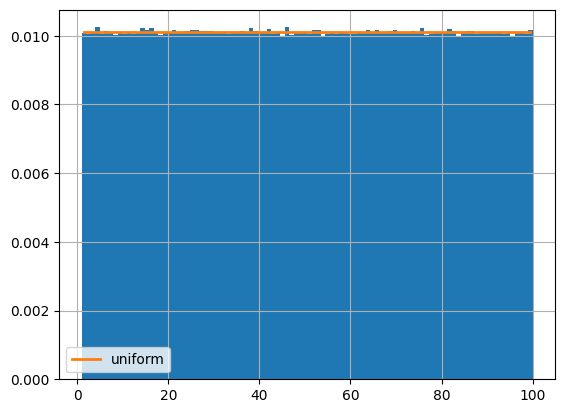

In [9]:
f = Fitter(weights_r, distributions=["uniform"], timeout=10)
f.fit()
f.summary()

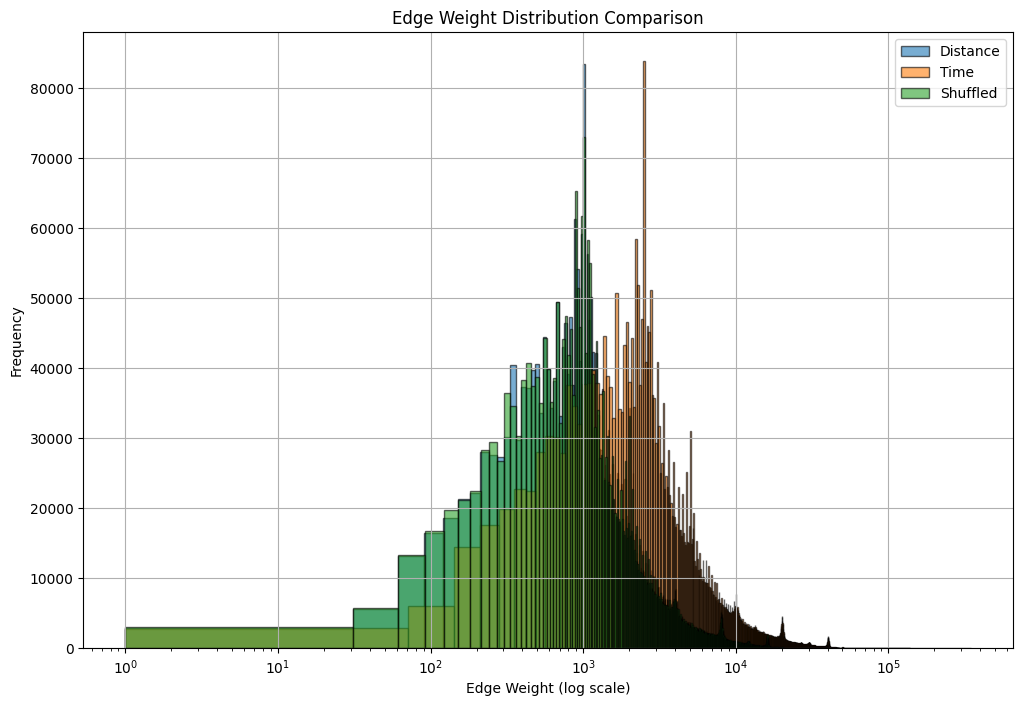

/tmp/ipykernel_8922/3130437166.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


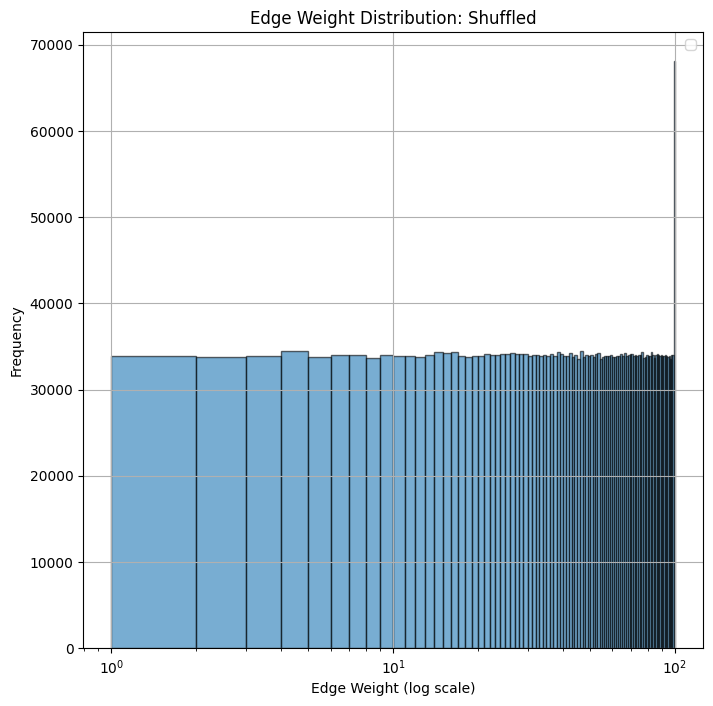

In [10]:
plt.figure(figsize=(12, 8))
plt.hist(weights_d, bins="auto", alpha=0.6, edgecolor="black", label="Distance")
plt.hist(weights_t, bins="auto", alpha=0.6, edgecolor="black", label="Time")
plt.hist(weights_s, bins="auto", alpha=0.6, edgecolor="black", label="Shuffled")

plt.xscale("log")
plt.xlabel("Edge Weight (log scale)")
plt.ylabel("Frequency")
plt.title("Edge Weight Distribution Comparison")
plt.legend()
plt.grid(True)
plt.show()

plot_weight_distribution(G_R, "Shuffled")